# **Дерево решений (CART)**
Дерево решений CART (Classification and Regressoin Tree) — алгоритм классификации и регрессии, основанный на бинарном дереве и являющийся фундаментальным компонентом случайного леса и бустингов, которые входят в число самых мощных алгоритмов машинного обучения на сегодняшний день.
Деревья также могут быть не бинарными в зависимости от реализации. К другим популярным реализациям решающего дерева относятся следующие: ID3, C4.5, C5.0.

### **Структура дерева решений**
Решающее дерево состоит из следующих компонентов: корневой узел, ветви (левая и правая), решающие и листовые (терминальные) узлы. Корневой и решающие узлы представляют из себя вопросы с пороговым значением для разделения тренировочного набора на части (левая и правая), а листья являются конечными прогнозами: среднее значений в листе для регрессии и статистическая мода для классификации.

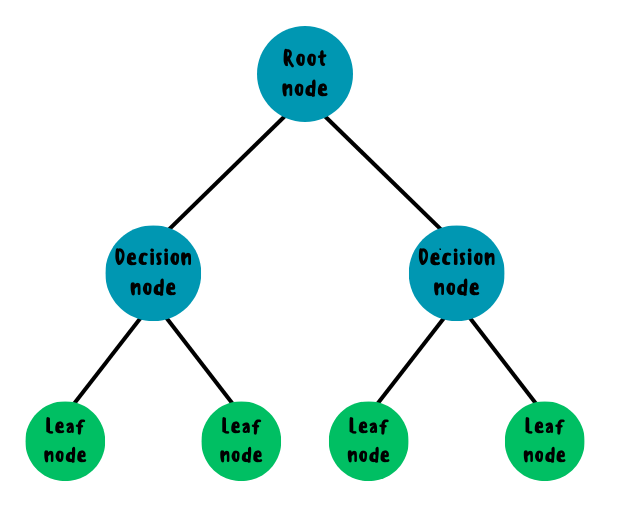

Каждый листовой узел соответствует определённой прямоугольной области на графике границ решений между двумя признаками. Если на графике соседние участки имеют одинаковое значение, то они автоматически объединяются и представляются как одна большая область.

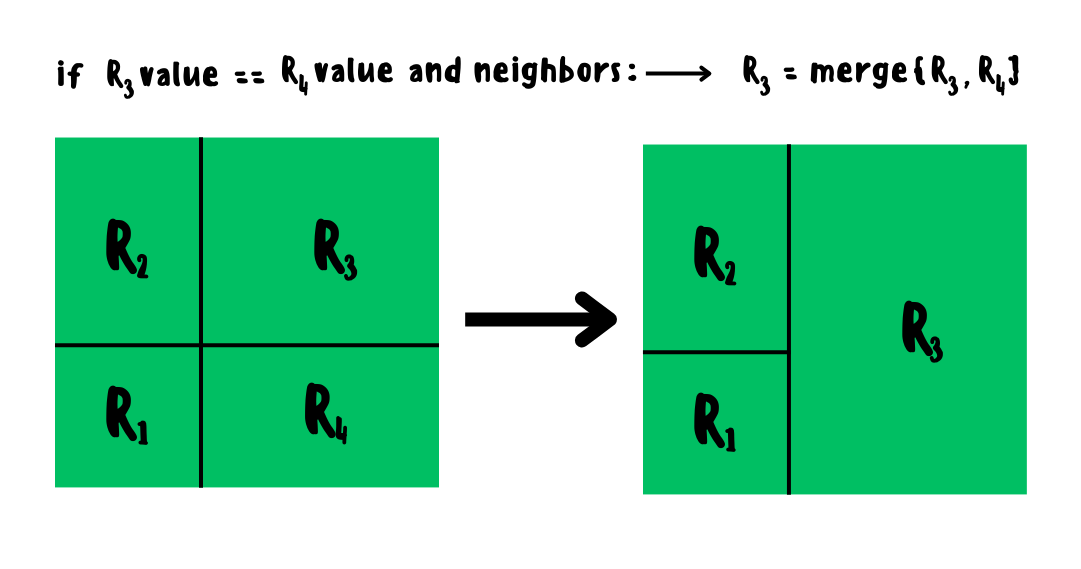

### **Выбор наилучшего разбиения**
Выбор наилучшего разбиения при построении решающего узла в дереве напоминает игру, в которой нужно угадать знаменитость, задавая вопросы, на которые можно лишь услышать ответ "да" либо "нет". Логично, что для быстрого поиска правильного ответа необходимо задавать вопросы, которые исключат наибольшее количество неверных вариантов, например, вопрос про "пол" позволит исключить сразу же половину вариантов, в то время как вопрос про "возраст" будет менее информативным. Проще говоря, выбор наилучшего вопроса заключается в поиске признака, определённое значение которого лучше всего отделяет правильный ответ от неправильных.

Показатель того, насколько хорошо вопрос в решающем узле позволяет отделить верный ответ от неверных, называется мерой загрязнённости узла. В случае классификации для оценки качества разбиения узла используются следующие критерии:
- Неопределённость (загрязнённость) Джини — мера разнообразия в распределении вероятностей классов. Если все элементы в узле принадлежат к одному классу, то неопределённость Джини равна 0, а в случае равномерного распределения классов в узле неопределённость Джини равна 0.5.

$$G_{i} = 1 - \sum\limits_{k = 1}^{n} P_{i,k}^{2} \quad \text{ - (Gini impurity of the } i^{th} \text{ node)}$$
- Энтропия Шеннона — мера неопределённости или беспорядка классов в узле. Она характеризует количество информации, которое необходимо для описания состояния системы: чем выше значение энтропии, тем менее упорядочена система и наоборот.

$S_{i} = - \sum\limits_{k = 1}^{n} P_{i,k} \ log_{2}P_{i,k} \ - \ $ Shannon's entropy
- Ошибка классификации — величина, отображающая долю неправильно классифицированных элементов в узле: чем меньше данное значение, тем меньше загрязнённость в узле.

$E_{i} = 1 - max\ P_{i,k} \ - \ $ missclassification error rate

$$P_{i, k} \quad \text{(- proportion of the } k^{th} \text{ class samples among the training samples in the } i^{th} \text{ node)}$$

На практике чаще всего используются неопределённость Джини и энтропия Шеннона за счёт большей информативности. Как видно из графика для случая бинарной классификации (где P+ — вероятность принадлежности к классу "+"), график удвоенной неопределённости Джини очень схож с графиком энтропии Шеннона: в первом случае будут получаться чуть менее сбалансированные деревья, однако при работе с большими датасетами неопределённость Джини более предпочтительна за счёт меньшей вычислительной сложности.



**Код для отрисовки графика**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def gini(probas):
    return np.array([1- (p ** 2 + (1-p) ** 2) for p in probas])


def entropy(probas):
    return np.array([-1 * (p * np.log2(p) + (1-p) * np.log2(1-p)) for p in probas])


def misclass_error_rate(probas):
    return np.array([1 - max([p, 1-p]) for p in probas])


probas = np.linspace(0, 1, 250)
plt.plot(probas, entropy(probas), label="Shannon's entropy")
plt.plot(probas, 2 * gini(probas),  label="Gini impurity x 2")
plt.plot(probas, 2 * misclass_error_rate(probas), label="Misclass error x 2")
plt.plot(probas, gini(probas), label="Gini impurity")
plt.plot(probas, misclass_error_rate(probas), label="Misclass error")
plt.title("Splitting criteria from P+ (binary classification case)")
plt.xlabel("P+")
plt.ylabel("Impurity")
plt.legend();

В случае регрессии для оценки качества разбиения узла чаще всего используется среднеквадратичная ошибка, но также могут быть использованы Friedman MSE и MAE.

### **Функция потерь**

Так как же в конечном счёте происходит выбор наилучшего разбиения? После выбора одного из критериев оценки качества разбиения узла (например, неопределённость Джини или MSE), для всех уникальных значений признака берутся их пороговые значения, отсортированные по возрастанию и представленные как среднее арифметическое между соседними значениями. Далее обучающий набор разделяется на 2 поднабора (узла): всё что меньше либо равно текущего порогового значения идёт в левый поднабор, а всё что больше — в правый. Для полученных поднаборов рассчитываются загрязнённости на основе выбранного критерия, после чего их взвешенная сумма представляется как функция потерь, значение которой будет соответствовать пороговому значению признака. Порог с наименьшим значением функции потерь в обучающем наборе (поднаборе) будет наилучшим разбиением.

Функции потерь будут иметь следующий вид:

$J(k, t_{k}) = \frac{N_{m}^{left}}{N_{m}} G_{left} +
\frac{N_{m}^{right}}{N_{m}} G_{right} \ - \ $ cost function for classification

$J(k, t_{k}) = \frac{N_{m}^{left}}{N_{m}} MSE_{left} +
\frac{N_{m}^{right}}{N_{m}} MSE_{right} \ - \ $ cost function for regression

$J(k, t_{k}) \to min$

В случае с энтропией используется немного иной подход: рассчитывается так называемый информационный прирост — разница энтропий родительского и дочерних узлов. Порог с максимальным информационным приростом в обучающем наборе/поднаборе будет соответствовать наилучшему разбиению:

$IG(Q) = S_{parent} - (\frac{N_{m}^{left}}{N_{m}} S_{child}^{left} +
\frac{N_{m}^{right}}{N_{m}} S_{child}^{right}) \to max \ - \ $ information gain

$Q \ -\  $ question(condition) for splitting of subset $m$


Для наглядности рассмотрим следующий пример. Допустим, у нас есть 4 кота и 4 собаки, а также нам известны их некоторые визуальные признаки: "рост", "уши" (висячие и заострённые стоячие) и "усы" (наличие либо отсутствие). Как в дереве решений строится корневой узел для классификации собак и котов? Очень просто: сначала для каждого признака животные разделяются на 2 группы согласно вопросу, после чего для каждой из групп рассчитывается неопределённость Джини. Пороговое значение признака с наименьшим значением функции потерь (взвешенной суммой неопределённостей) будет использоваться для разбиения корневого (решающего) узла. В данном случае признак "рост" имеет наименьшую загрязнённость и вопрос в решающем узле будет выглядеть как "рост ⩽ 20 см". Стоит добавить, что в случае с категориальными признаками происходит их бинаризация и вопросы выглядят следующим образом: "уши ⩽ 0.5", "усы ⩽ 0.5". Когда категориальные признаки могут принимать более 2 значений, применяются другие виды кодирования, например label или one-hot encoding.

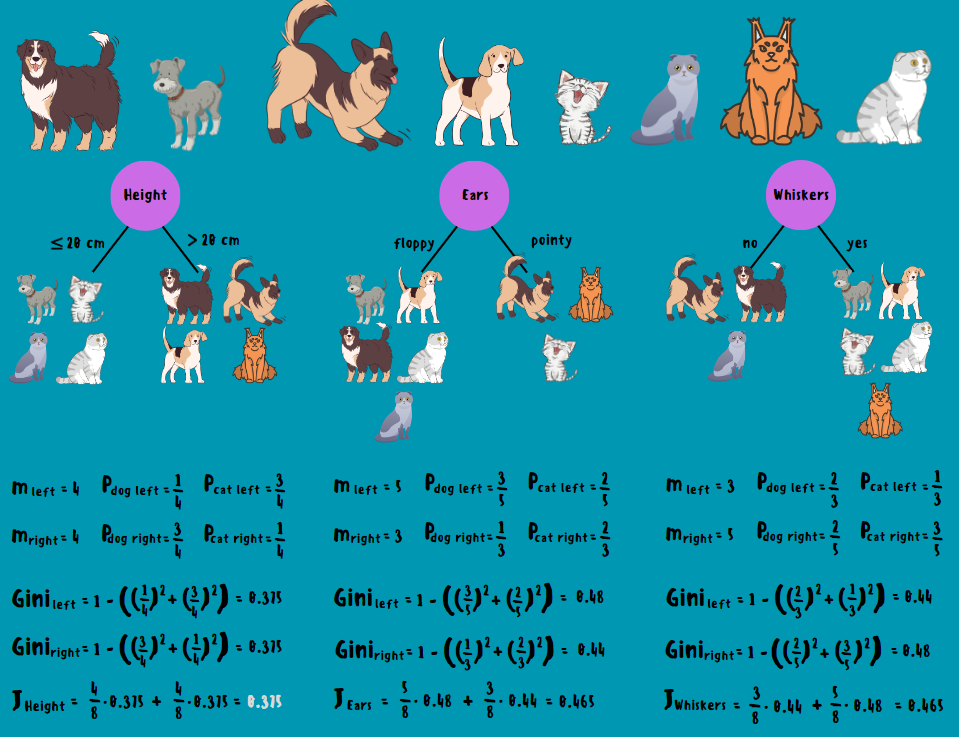

### **Принцип работы дерева решений (CART)**
Алгоритм строится следующим образом:
- 1) создаётся корневой узел на основе наилучшего разбиения;
- 2) тренировочный набор разбивается на 2 поднабора: всё что соответствует условию разбиения отправляется в левый узел, остальное — в правый;
- 3) далее рекурсивно для каждого тренировочного поднабора повторяются шаги 1-2 пока не будет достигнут один из основных критериев останова: максимальная глубина, максимальное количество листьев, минимальное количество наблюдений в листе или минимальное снижение загрязнения в узле.


### **Регуляризация дерева решений**
Выращенная без ограничений древовидная структура в той или иной степени будет склонна к переобучению и для решения данной проблемы используется 2 подхода: *pre-pruning* (ограничение роста дерева во время построения любым из критериев останова) и *post-pruning* (отсечение лишних ветвей после полного построения). Второй подход является более деликатным так как позволяет получить несимметричную и более точную древовидную структуру, оставляя лишь самые информативные решающие узлы.

Существует 2 типа post-puning'а:
- **Top-down pruning** — метод, при котором проверка и обрезка наименее информативных ветвей начинается с корневого узла. Данный метод обладает относительно низкой вычислительной сложностью, однако, как и в случае с pre-pruning'ом, его главным недостатком также является возможность недообучения за счёт удаления ветвей, которые могли потенциально содержать информативные узлы. К самым известным видам данного прунинга относятся следующие:
 - *Pessimistic Error Pruning (PEP)*, когда обрезаются ветви с наибольшей ожидаемой ошибкой, порог которой устанавливается заранее;
 - *Critical Value Pruning (CVP)*, когда обрезаются ветви, информативность которых меньше определённого критического значения.

- **Bottom-up pruning** — метод, при котором проверка и обрезка наименее информативных ветвей начинается с листьев. В данном случае получаются более точные деревья за счёт полного обхода снизу-вверх и оценки каждого решающего узла, однако это приводит к увеличению вычислительной сложности. Самыми популярными видами данного прунинга являются следующие:
 - *Minimum Error Pruning (MEP)*, когда происходит поиск дерева с наименьшей ожидаемой ошибкой на отложенной выборке;
 - *Reduced Error Pruning (REP)*, когда решающие узлы удаляются до тех пор, пока не падает точность, измеренная на отложенной выборке;
 - *Cost-complexity pruning (CCP)*, когда строится серия поддеревьев через удаление слабейших узлов в каждом из них с помощью коэффициента, рассчитанного как разность ошибки корневого узла поддерева и общей ошибки его листьев, а выбор наилучшего поддерева производится на тестовом наборе или с помощью k-fold кросс-валидации.

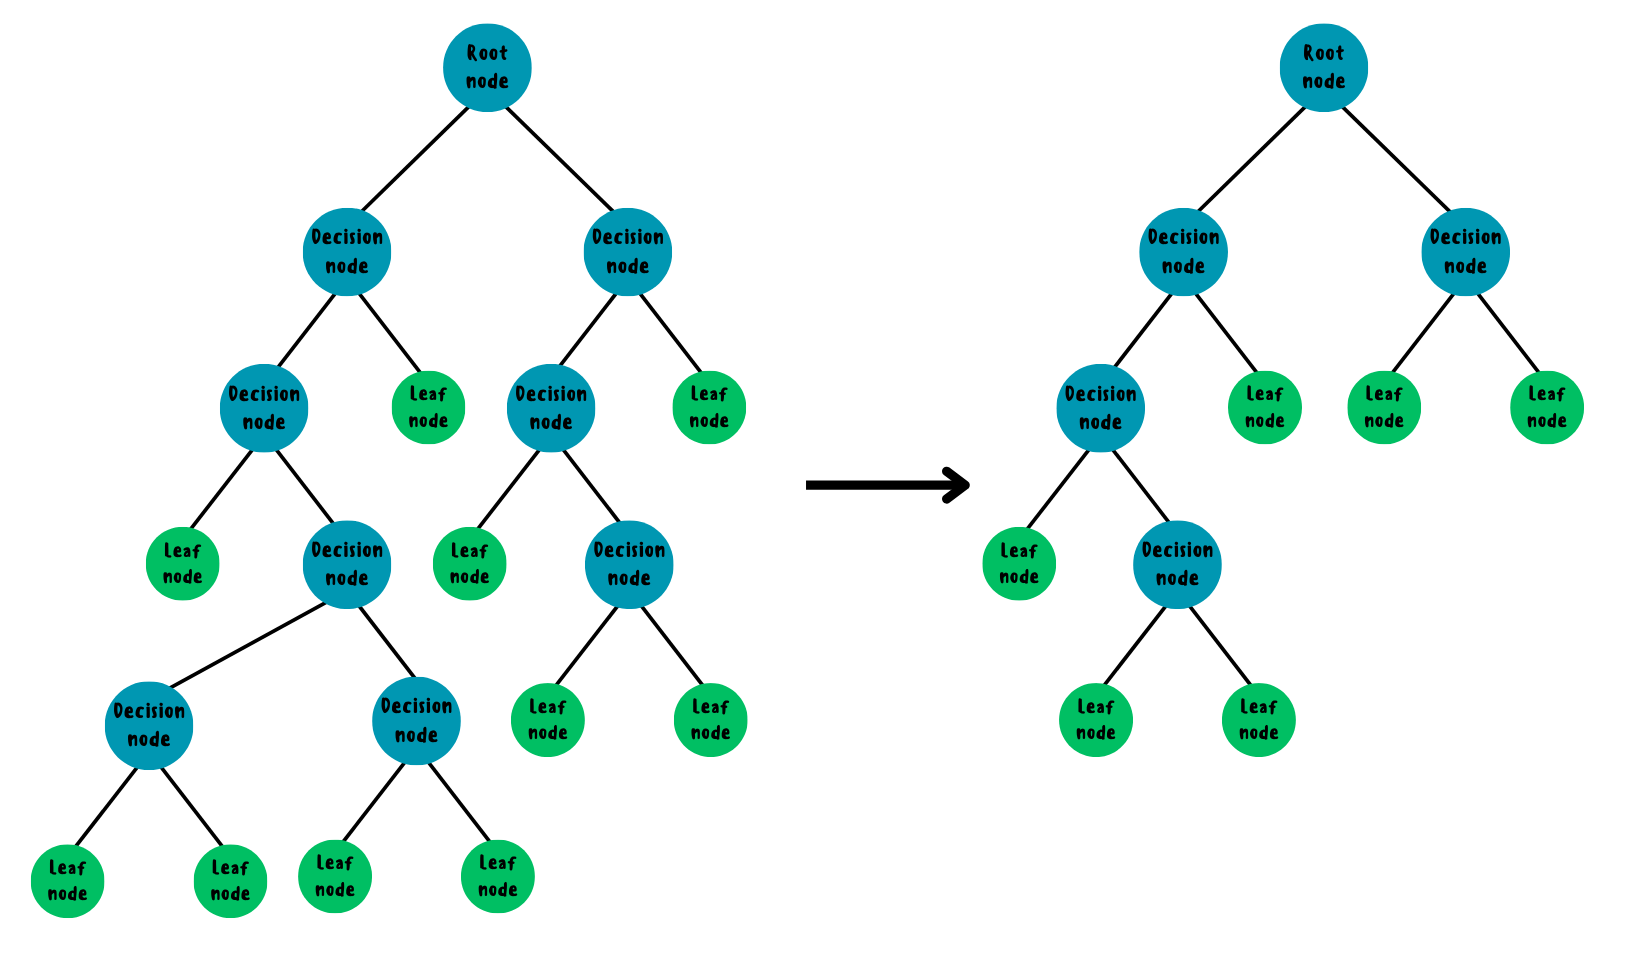

### **Minimal cost-complexity pruning**

В реализации scikit-learn для деревьев решений используется модификация cost-complexity pruning, которая работает следующим образом:
- 1) сначала строится полное дерево без ограничений;
- 2) далее абсолютно для всех узлов в дереве рассчитывается ошибка на основе взвешенной загрязнённости в случае классификации или взвешенной MSE в случае регрессии;
- 3) для каждого поддерева в дереве подсчитывается совокупная ошибка его листьев;
- 4) для каждого поддерева в дереве рассчитывается коэффициент альфа, представленный как разность ошибки корневого узла поддерева и совокупная ошибка его листьев;
- 5) поддерево с наименьшим $\alpha_{ccp}$ удаляется и становится листовым узлом, а сам коэффициент хранится в массиве cost_complety_pruning_path и соответствует новому обрезанному дереву;
- 6) шаги 2-5 рекурсивно повторяются для каждого поддерева до тех пор, пока обрезка не дойдёт до корневого узла.

Если задавать определённое значение $\alpha_{ccp}$ изначально, то данный коэффициент применится к каждому поддереву и в итоге останется поддерево с наименьшей ошибкой среди всех поддеревьев, а выбор наилучшего $\alpha_{ccp}$ из cost_complety_pruning_path для получения самого точного поддерева производится на тестовом наборе или с помощью k-fold кросс-валидации.

**Формулы для расчётов**

$R_\alpha(T) = R(T) + \alpha|\widetilde{T}| \ - \ $ regularization

$\alpha_{ccp} = \frac{R_{t} - R(T_{t})}{|T| - 1} \ - \ $ effective ccp alpha

$R_{node} = \frac{N_{m}}{N} G_{m} \ - \ $ decision ($R_{t}$) or a leaf node $R(T)$ error rate
for classification

$R_{node} = \frac{N_{m}}{N} MSE_{m} \ - \ $ decision ($R_{t}$) or a leaf node $R(T)$ error rate
for regression

$R(T_{t}) = \sum\limits_{i=1}^{n} R(T_{i})\ - \ $ total leaf error rate of a tree/subtree

$T \ - \ $  number of terminal (leaf) nodes

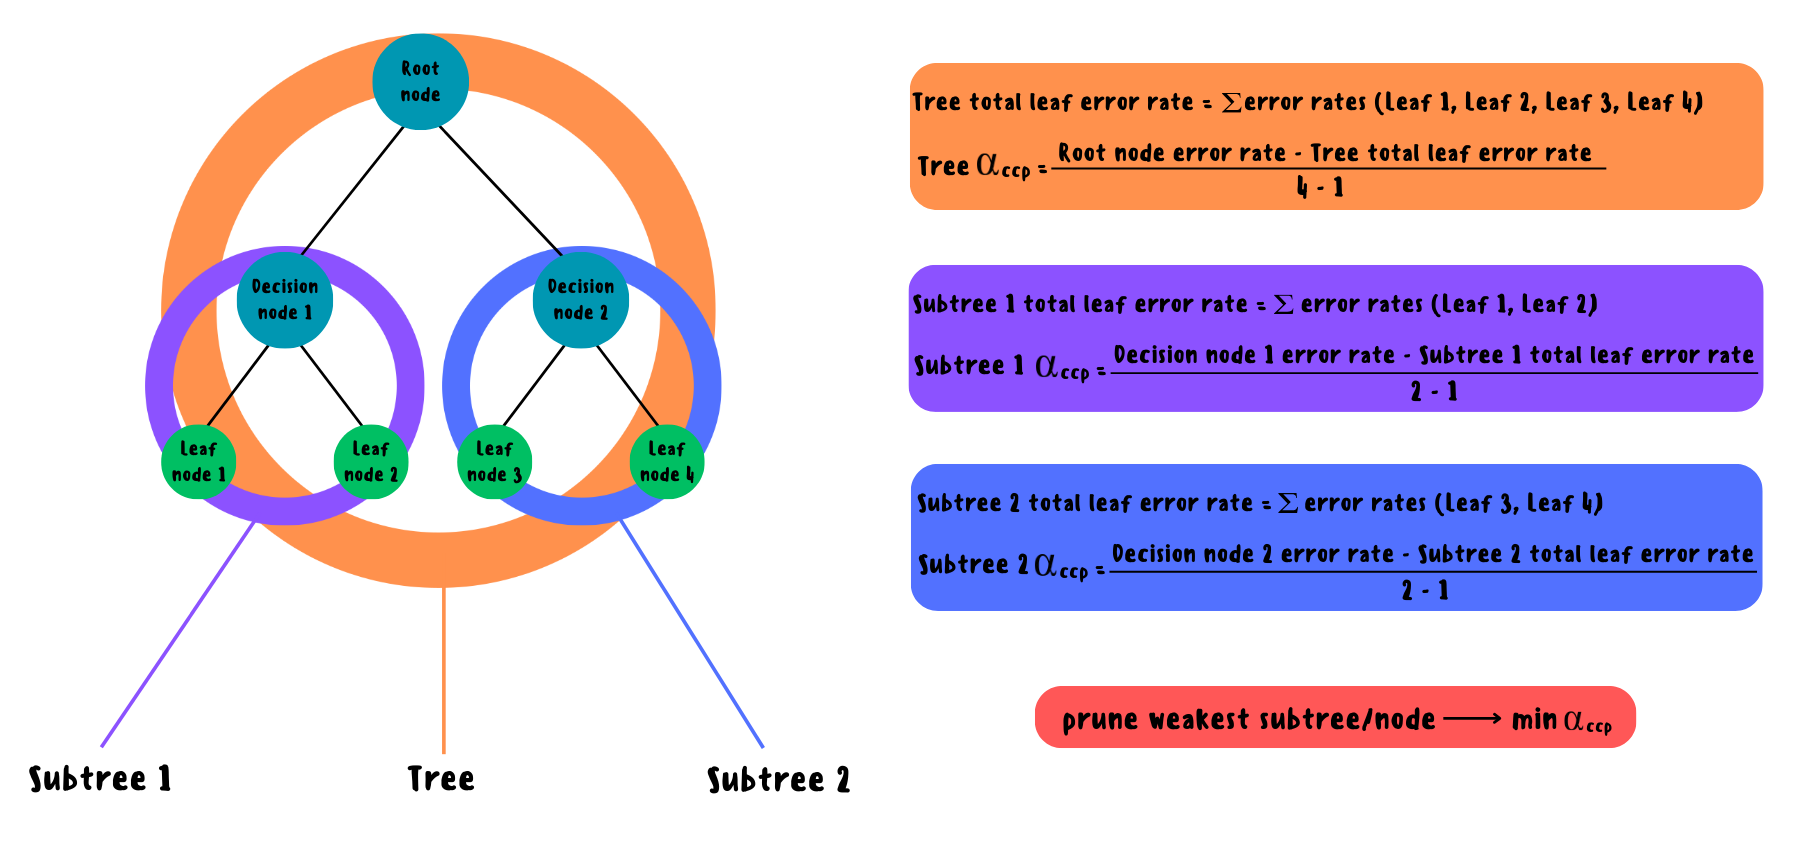

### **Реализация на Python с нуля**
В оригинальном дереве для создания узлов и хранения в них информации используется отдельный класс, но в данном случае дерево и вся информация об узлах хранятся в словаре с ключами в строчном формате. Такое изменение используется для возможности вывода полученного дерева и сравнения с реализацией scikit-learn.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_linnerud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from mlxtend.plotting import plot_decision_regions
from copy import deepcopy
from pprint import pprint

In [16]:
class DecisionTreeCART:

    def __init__(self, max_depth=100, min_samples=2, ccp_alpha=0.0, regression=False):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.ccp_alpha = ccp_alpha
        self.regression = regression
        self.tree = None
        self._y_type = None
        self._num_all_samples = None

    def _set_df_type(self, X, y, dtype):
        X = X.astype(dtype)
        y = y.astype(dtype) if self.regression else y
        self._y_dtype = y.dtype

        return X, y

    @staticmethod
    def _purity(y):
        unique_classes = np.unique(y)

        return unique_classes.size == 1

    @staticmethod
    def _is_leaf_node(node):
        return not isinstance(node, dict)   # if a node/tree is a leaf

    def _leaf_node(self, y):
        class_index = 0

        return np.mean(y) if self.regression else y.mode()[class_index]

    def _split_df(self, X, y, feature, threshold):
        feature_values = X[feature]
        left_indexes = X[feature_values <= threshold].index
        right_indexes = X[feature_values > threshold].index
        sizes = np.array([left_indexes.size, right_indexes.size])

        return self._leaf_node(y) if any(sizes == 0) else left_indexes, right_indexes

    @staticmethod
    def _gini_impurity(y):
        _, counts_classes = np.unique(y, return_counts=True)
        squared_probabilities = np.square(counts_classes / y.size)
        gini_impurity = 1 - sum(squared_probabilities)

        return gini_impurity

    @staticmethod
    def _mse(y):
        mse = np.mean((y - y.mean()) ** 2)

        return mse

    @staticmethod
    def _cost_function(left_df, right_df, method):
        total_df_size = left_df.size + right_df.size
        p_left_df = left_df.size / total_df_size
        p_right_df = right_df.size / total_df_size
        J_left = method(left_df)
        J_right = method(right_df)
        J = p_left_df*J_left + p_right_df*J_right

        return J  # weighted Gini impurity or weighted mse (depends on a method)

    def _node_error_rate(self, y, method):
        if self._num_all_samples is None:
            self._num_all_samples = y.size   # num samples of all dataframe
        current_num_samples = y.size

        return current_num_samples / self._num_all_samples * method(y)

    def _best_split(self, X, y):
        features = X.columns
        min_cost_function = np.inf
        best_feature, best_threshold = None, None
        method = self._mse if self.regression else self._gini_impurity

        for feature in features:
            unique_feature_values = np.unique(X[feature])

            for i in range(1, len(unique_feature_values)):
                current_value = unique_feature_values[i]
                previous_value = unique_feature_values[i-1]
                threshold = (current_value + previous_value) / 2
                left_indexes, right_indexes = self._split_df(X, y, feature, threshold)
                left_labels, right_labels = y.loc[left_indexes], y.loc[right_indexes]
                current_J = self._cost_function(left_labels, right_labels, method)

                if current_J <= min_cost_function:
                    min_cost_function = current_J
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _stopping_conditions(self, y, depth, n_samples):
        return self._purity(y), depth == self.max_depth, n_samples < self.min_samples

    def _grow_tree(self, X, y, depth=0):
        current_num_samples = y.size
        X, y = self._set_df_type(X, y, np.float128)
        method = self._mse if self.regression else self._gini_impurity

        if any(self._stopping_conditions(y, depth, current_num_samples)):
            RTi = self._node_error_rate(y, method)   # leaf node error rate
            leaf_node = f'{self._leaf_node(y)} | error_rate {RTi}'
            return leaf_node

        Rt = self._node_error_rate(y, method)   # decision node error rate
        best_feature, best_threshold = self._best_split(X, y)
        decision_node = f'{best_feature} <= {best_threshold} | ' \
                        f'as_leaf {self._leaf_node(y)} error_rate {Rt}'

        left_indexes, right_indexes = self._split_df(X, y, best_feature, best_threshold)
        left_X, right_X = X.loc[left_indexes], X.loc[right_indexes]
        left_labels, right_labels = y.loc[left_indexes], y.loc[right_indexes]

        # recursive part
        tree = {decision_node: []}
        left_subtree = self._grow_tree(left_X, left_labels, depth+1)
        right_subtree = self._grow_tree(right_X, right_labels, depth+1)

        if left_subtree == right_subtree:
            tree = left_subtree
        else:
            tree[decision_node].extend([left_subtree, right_subtree])

        return tree

    def _tree_error_rate_info(self, tree, error_rates_list):
        if self._is_leaf_node(tree):
            *_, leaf_error_rate = tree.split()
            error_rates_list.append(np.float128(leaf_error_rate))
        else:
            decision_node = next(iter(tree))
            left_subtree, right_subtree = tree[decision_node]
            self._tree_error_rate_info(left_subtree, error_rates_list)
            self._tree_error_rate_info(right_subtree, error_rates_list)

        RT = sum(error_rates_list)   # total leaf error rate of a tree
        num_leaf_nodes = len(error_rates_list)

        return RT, num_leaf_nodes

    @staticmethod
    def _ccp_alpha_eff(decision_node_Rt, leaf_nodes_RTt, num_leafs):

        return (decision_node_Rt - leaf_nodes_RTt) / (num_leafs - 1)

    def _find_weakest_node(self, tree, weakest_node_info):
        if self._is_leaf_node(tree):
            return tree

        decision_node = next(iter(tree))
        left_subtree, right_subtree = tree[decision_node]
        *_, decision_node_error_rate = decision_node.split()

        Rt = np.float128(decision_node_error_rate)
        RTt, num_leaf_nodes = self._tree_error_rate_info(tree, [])
        ccp_alpha = self._ccp_alpha_eff(Rt, RTt, num_leaf_nodes)
        decision_node_index, min_ccp_alpha_index = 0, 1

        if ccp_alpha <= weakest_node_info[min_ccp_alpha_index]:
            weakest_node_info[decision_node_index] = decision_node
            weakest_node_info[min_ccp_alpha_index] = ccp_alpha

        self._find_weakest_node(left_subtree, weakest_node_info)
        self._find_weakest_node(right_subtree, weakest_node_info)

        return weakest_node_info

    def _prune_tree(self, tree, weakest_node):
        if self._is_leaf_node(tree):
            return tree

        decision_node = next(iter(tree))
        left_subtree, right_subtree = tree[decision_node]
        left_subtree_index, right_subtree_index = 0, 1
        _, leaf_node = weakest_node.split('as_leaf ')

        if weakest_node is decision_node:
            tree = weakest_node
        if weakest_node in left_subtree:
            tree[decision_node][left_subtree_index] = leaf_node
        if weakest_node in right_subtree:
            tree[decision_node][right_subtree_index] = leaf_node

        self._prune_tree(left_subtree, weakest_node)
        self._prune_tree(right_subtree, weakest_node)

        return tree

    def cost_complexity_pruning_path(self, X: pd.DataFrame, y: pd.Series):
        tree = self._grow_tree(X, y)   # grow a full tree
        tree_error_rate, _ = self._tree_error_rate_info(tree, [])
        error_rates = [tree_error_rate]
        ccp_alpha_list = [0.0]

        while not self._is_leaf_node(tree):
            initial_node = [None, np.inf]
            weakest_node, ccp_alpha = self._find_weakest_node(tree, initial_node)
            tree = self._prune_tree(tree, weakest_node)
            tree_error_rate, _ = self._tree_error_rate_info(tree, [])

            error_rates.append(tree_error_rate)
            ccp_alpha_list.append(ccp_alpha)

        return np.array(ccp_alpha_list), np.array(error_rates)

    def _ccp_tree_error_rate(self, tree_error_rate, num_leaf_nodes):

        return tree_error_rate + self.ccp_alpha*num_leaf_nodes   # regularization

    def _optimal_tree(self, X, y):
        tree = self._grow_tree(X, y)   # grow a full tree
        min_RT_alpha, final_tree = np.inf, None

        while not self._is_leaf_node(tree):
            RT, num_leaf_nodes = self._tree_error_rate_info(tree, [])
            current_RT_alpha = self._ccp_tree_error_rate(RT, num_leaf_nodes)

            if current_RT_alpha <= min_RT_alpha:
                min_RT_alpha = current_RT_alpha
                final_tree = deepcopy(tree)

            initial_node = [None, np.inf]
            weakest_node, _ = self._find_weakest_node(tree, initial_node)
            tree = self._prune_tree(tree, weakest_node)

        return final_tree

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self.tree = self._optimal_tree(X, y)

    def _traverse_tree(self, sample, tree):
        if self._is_leaf_node(tree):
            leaf, *_ = tree.split()
            return leaf

        decision_node = next(iter(tree))  # dict key
        left_node, right_node = tree[decision_node]
        feature, other = decision_node.split(' <=')
        threshold, *_ = other.split()
        feature_value = sample[feature]

        if np.float128(feature_value) <= np.float128(threshold):
            next_node = self._traverse_tree(sample, left_node)    # left_node
        else:
            next_node = self._traverse_tree(sample, right_node)   # right_node

        return next_node

    def predict(self, samples: pd.DataFrame):
        # apply traverse_tree method for each row in a dataframe
        results = samples.apply(self._traverse_tree, args=(self.tree,), axis=1)

        return np.array(results.astype(self._y_dtype))

In [17]:
def tree_plot(sklearn_tree, Xa_train):
    plt.figure(figsize=(12, 18))  # customize according to the size of your tree
    plot_tree(sklearn_tree, feature_names=Xa_train.columns, filled=True, precision=6)
    plt.show()


def tree_scores_plot(estimator, ccp_alphas, train_data, test_data, metric, labels):
    train_scores, test_scores = [], []
    X_train, y_train = train_data
    X_test, y_test = test_data
    x_label, y_label = labels

    for ccp_alpha_i in ccp_alphas:
        estimator.ccp_alpha = ccp_alpha_i
        estimator.fit(X_train, y_train)
        train_pred_res = estimator.predict(X_train)
        test_pred_res = estimator.predict(X_test)

        train_score = metric(y_train, train_pred_res)
        test_score = metric(y_test, test_pred_res)
        train_scores.append(train_score)
        test_scores.append(test_score)

    fig, ax = plt.subplots()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f"{y_label} vs {x_label} for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
    ax.legend()
    plt.show()


def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    if y.dtype != 'int':
        y = pd.Series(LabelEncoder().fit_transform(y))
        y_train = pd.Series(LabelEncoder().fit_transform(y_train))

    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train.values[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train.values)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

### **Загрузка датасетов**
Для обучения моделей будет использован [Iris dataset](https://www.kaggle.com/datasets/himanshunakrani/iris-dataset), где необходимо верно определить типы цветков на основе их признаков. В случае регрессии используется load_linnerud dataset из scikit-learn.

In [ ]:
df_path = "/content/drive/MyDrive/iris.csv"
iris = pd.read_csv(df_path)
X1, y1 = iris.iloc[:, :-1], iris.iloc[:, -1]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=0)
print(iris)

In [ ]:
X2, y2 = load_linnerud(return_X_y=True, as_frame=True)
y2 = y2['Pulse']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=0)
print(X2, y2, sep='\n')

### **Обучение моделей и оценка полученных результатов**
В случае классификации дерево на данных ирис показало высокую точность. После прунинга точность не увеличилась, зато удалось найти более оптимальное дерево (alpha=0.0143) с такой же точностью и меньшим количеством узлов.

А вот в случае регрессии удалось получить прирост в плане точности, подобрав alpha=3.613, которое создаёт дерево с минимальной ошибкой на тестовом наборе. Все результаты приведены ниже.

**Классификация до прунинга**

In [ ]:
tree_classifier = DecisionTreeCART()
tree_classifier.fit(X1_train, y1_train)
clf_ccp_alphas, _ = tree_classifier.cost_complexity_pruning_path(X1_train, y1_train)
clf_ccp_alphas = clf_ccp_alphas[:-1]

sk_tree_classifier = DecisionTreeClassifier(random_state=0)
sk_tree_classifier.fit(X1_train, y1_train)
sk_clf_path = sk_tree_classifier.cost_complexity_pruning_path(X1_train, y1_train)
sk_clf_ccp_alphas = sk_clf_path.ccp_alphas[:-1]

sk_clf_estimator = DecisionTreeClassifier(random_state=0)
train1_data, test1_data = [X1_train, y1_train], [X1_test, y1_test]
metric = accuracy_score
labels = ['Alpha', 'Accuracy']

pprint(tree_classifier.tree, width=180)
tree_plot(sk_tree_classifier, X1_train)
print(f'tree alphas: {clf_ccp_alphas}', f'sklearn alphas: {sk_clf_ccp_alphas}', sep='\n')
tree_scores_plot(sk_clf_estimator, clf_ccp_alphas, train1_data, test1_data, metric, labels)

**Классификация после прунинга**

In [ ]:
tree_clf_prediction = tree_classifier.predict(X1_test)
tree_clf_accuracy = accuracy_score(y1_test, tree_clf_prediction)
sk_tree_clf_prediction = sk_tree_classifier.predict(X1_test)
sk_clf_accuracy = accuracy_score(y1_test, sk_tree_clf_prediction)

best_clf_ccp_alpha = 0.0143 # based on a plot
best_tree_classifier = DecisionTreeCART(ccp_alpha=best_clf_ccp_alpha)
best_tree_classifier.fit(X1_train, y1_train)
best_tree_clf_prediction = best_tree_classifier.predict(X1_test)
best_tree_clf_accuracy = accuracy_score(y1_test, best_tree_clf_prediction)

best_sk_tree_classifier = DecisionTreeClassifier(random_state=0, ccp_alpha=best_clf_ccp_alpha)
best_sk_tree_classifier.fit(X1_train, y1_train)
best_sk_tree_clf_prediction = best_sk_tree_classifier.predict(X1_test)
best_sk_clf_accuracy = accuracy_score(y1_test, best_sk_tree_clf_prediction)

print('tree prediction', tree_clf_prediction, ' ', sep='\n')
print('sklearn prediction', sk_tree_clf_prediction, ' ', sep='\n')
print('best tree prediction', best_tree_clf_prediction, ' ', sep='\n')
print('best sklearn prediction', best_sk_tree_clf_prediction, ' ', sep='\n')

pprint(best_tree_classifier.tree, width=180)
tree_plot(best_sk_tree_classifier, X1_train)
print(f'our tree pruning accuracy: before {tree_clf_accuracy} -> after {best_tree_clf_accuracy}')
print(f'sklearn tree pruning accuracy: before {sk_clf_accuracy} -> after {best_sk_clf_accuracy}')

**Прунинг при разных ccp alpha**

In [ ]:
feature_indexes = [2, 3]
title1 = 'Classification tree surface before pruning'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_tree_classifier, feature_indexes, title1)

In [ ]:
feature_indexes = [2, 3]
title2 = 'Classification tree surface after pruning'
decision_boundary_plot(X1, y1, X1_train, y1_train, best_sk_tree_classifier, feature_indexes, title2)

In [ ]:
feature_indexes = [2, 3]
plt.figure(figsize=(10, 15))

for i, alpha in enumerate(clf_ccp_alphas):
    sk_tree_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(hspace=0.5)
    title = f'ccp_alpha = {alpha}'
    decision_boundary_plot(X1, y1, X1_train, y1_train, sk_tree_clf, feature_indexes, title)

**Регрессия до прунинга**

In [ ]:
tree_regressor = DecisionTreeCART(regression=True)
tree_regressor.fit(X2_train, y2_train)
reg_ccp_alphas, _ = tree_regressor.cost_complexity_pruning_path(X2_train, y2_train)
reg_ccp_alphas = reg_ccp_alphas[:-1]

sk_tree_regressor = DecisionTreeRegressor(random_state=0)
sk_tree_regressor.fit(X2_train, y2_train)
sk_reg_path = sk_tree_regressor.cost_complexity_pruning_path(X2_train, y2_train)
sk_reg_ccp_alphas = sk_reg_path.ccp_alphas[:-1]

reg_estimator = DecisionTreeCART(regression=True)
sk_reg_estimator = DecisionTreeRegressor(random_state=0)
train2_data, test2_data = [X2_train, y2_train], [X2_test, y2_test]
metric = mean_absolute_percentage_error
labels = ['Alpha', 'MAPE']

pprint(tree_regressor.tree)
tree_plot(sk_tree_regressor, X2_train)

print(f'CART alphas: {reg_ccp_alphas}')
tree_scores_plot(reg_estimator, reg_ccp_alphas, train2_data, test2_data, metric, labels)
print(f'sklearn_alphas: {sk_reg_ccp_alphas}')
tree_scores_plot(sk_reg_estimator, sk_reg_ccp_alphas, train2_data, test2_data, metric, labels)

**Регрессия после прунинга**

In [ ]:
tree_reg_prediction = tree_regressor.predict(X2_test)
tree_reg_error = mean_absolute_percentage_error(y2_test, tree_reg_prediction)
sk_tree_reg_prediction = sk_tree_regressor.predict(X2_test)
sk_reg_error= mean_absolute_percentage_error(y2_test, sk_tree_reg_prediction)

best_reg_ccp_alpha = 3.613   # based on a plot
best_tree_regressor = DecisionTreeCART(ccp_alpha=best_reg_ccp_alpha, regression=True)
best_tree_regressor.fit(X2_train, y2_train)
best_tree_reg_prediction = best_tree_regressor.predict(X2_test)
lowest_tree_reg_error = mean_absolute_percentage_error(y2_test, best_tree_reg_prediction)

best_sk_tree_regressor = DecisionTreeRegressor(random_state=0, ccp_alpha=best_reg_ccp_alpha)
best_sk_tree_regressor.fit(X2_train, y2_train)
best_sk_tree_reg_prediction = best_sk_tree_regressor.predict(X2_test)
lowest_sk_reg_error = mean_absolute_percentage_error(y2_test, best_sk_tree_reg_prediction)

print('tree prediction', tree_reg_prediction, ' ', sep='\n')
print('sklearn prediction', sk_tree_reg_prediction, ' ', sep='\n')
print('best tree prediction', best_tree_reg_prediction, ' ', sep='\n')
print('best sklearn prediction', best_sk_tree_reg_prediction, ' ', sep='\n')

pprint(best_tree_regressor.tree)
tree_plot(best_sk_tree_regressor, X2_train)
print(f'tree error: before {tree_reg_error} -> after pruning {lowest_tree_reg_error}')
print(f'sklearn tree error: before {sk_reg_error} -> after pruning {lowest_sk_reg_error}')

### **Преимущества и недостатки дерева решений**

Преимущества:
- простота в интерпретации и визуализации;
- неплохая работа с нелинейными зависимостями в данных;
- не требуется особой подготовки тренировочного набора;
- относительно высокая скорость обучения и прогнозирования.

Недостатки:
- поиск оптимального дерева является NP-полной задачей;
- нестабильность работы даже при небольшом изменении данных;
- возможность переобучения из-за чувствительности к шуму и выбросам в данных.

### **Дополнительные источники**
Статья «The CART Decision Tree for Mining Data Streams», Leszek Rutkowskia, Maciej Jaworskia, Lena Pietruczuka, Piotr Dudaa.

Документация:
- [описание CART](https://scikit-learn.org/stable/modules/tree.html#);
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html);
- [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html);
- [pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html).

Лекции: [один](https://www.youtube.com/watch?v=KEprOSyrOVY), [два](https://www.youtube.com/watch?v=1I5MBdkpWgo), [три](https://www.youtube.com/watch?v=5aIFgrrTqOw;), [четыре](https://www.youtube.com/watch?v=5O8HvA9pMew/).

Пошаговое построение дерева решений: [один](https://www.youtube.com/playlist?list=PLPOTBrypY74xS3WD0G_uzqPjCQfU6IRK-), [два](https://www.youtube.com/watch?v=_L39rN6gz7Y), [три](https://www.youtube.com/watch?v=g9c66TUylZ4).

Pruning:
- [Статья](https://www.programmersought.com/article/47967993808/).
  
- Видео: [один](https://www.youtube.com/watch?v=Tg2OGohaUTc), [два](https://www.youtube.com/watch?v=D0efHEJsfHo), [три](https://www.youtube.com/watch?v=4VAOjWCHzXk).